In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer


from trabalho_ic_aplicada.models import aux
from trabalho_ic_aplicada.models.reg_perceptron import treinar_perceptron_reg, prever_perceptron_reg

2025-07-19 08:56:54.785 | INFO     | trabalho_ic_aplicada.config:<module>:11 - PROJ_ROOT path is: /home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada


In [2]:
# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

features = real_estate_valuation.variables.iloc[1:, 0].values
# data (as pandas dataframes)
X = real_estate_valuation.data.features.to_numpy()

# Removendo a primeira coluna (X1 transaction date) que não é um atributo relevante, segundo analise.
X = X[:, 1:]

y = real_estate_valuation.data.targets.to_numpy().ravel()


k_fold = aux.validacao_cruzada_kfold(X,y,k=10)


Erro Quadrático Médio (EQM): 72.3646 ± 58.5241
Raiz do Erro Quadrático Médio (REQM): 8.0254 ± 2.8210
Hit rate 20%: 0.7230 ± 0.0815
Hit rate 10%: 0.4187 ± 0.1023

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.7862 ± 0.0123
Correlação Média (Teste): 0.7998 ± 0.0906
Coeficiente de Determinação (R²): 0.6337 ± 0.1386

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.8514, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8543, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


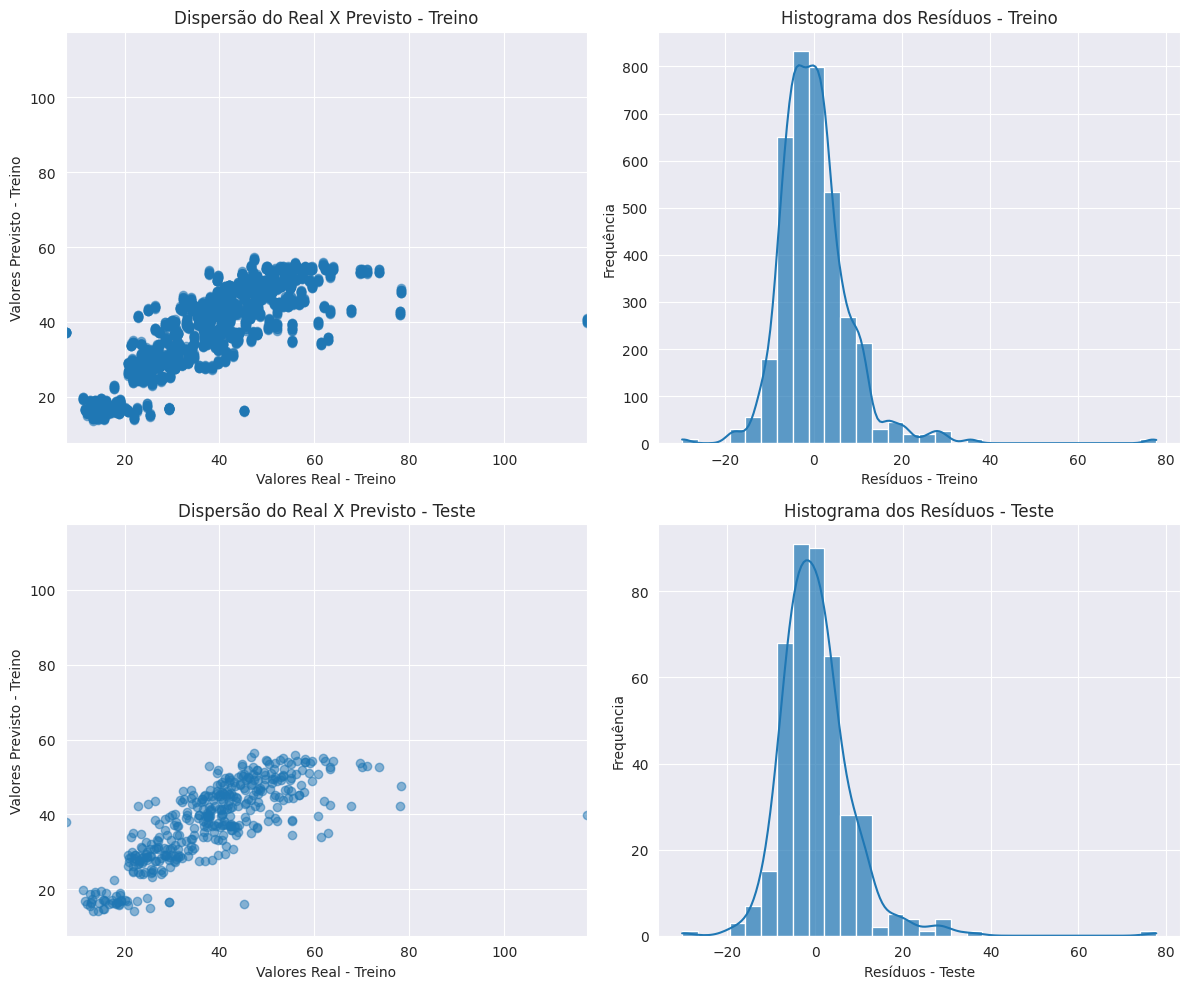

In [3]:
# %%time
# --- Parâmetros da Simulação ---
n_epocas = 100
n_rodadas = 10
taxa_aprendizagem = 0.001
pct_treino = 0.8

# Listas para métricas
eqms_iqr = []
reqms_iqr = []
r_quadrados_iqr = []
hit_rates_20_iqr = []
hit_rates_10_iqr = []

# Listas para resíduos e correlações
correlacoes_treino = []
correlacoes_teste = []

# Listas para análise final
y_trains = []
y_train_preds = []
y_tests = []
y_test_preds = []

# Loop de validação cruzada
for k in range(len(k_fold)):
    # Dados de treino
    X_train_k = X[k_fold[k][0], :]
    y_train_k = y[k_fold[k][0]]

    # Normalização
    scaler = QuantileTransformer(n_quantiles=X_train_k.shape[0], output_distribution='uniform')
    X_train_k = scaler.fit_transform(X_train_k)

    # Treinamento
    w, curva_loss = treinar_perceptron_reg(X_train_k, y_train_k, n_epocas, taxa_aprendizagem)

    # Previsão Treino
    y_pred_train = prever_perceptron_reg(X_train_k, w)
    corr_treino = np.corrcoef(y_train_k.flatten(), y_pred_train.flatten())[0, 1]
    correlacoes_treino.append(corr_treino)

    X_test_k = X[k_fold[k][1], :]
    y_test_k = y[k_fold[k][1]]
    X_test_k = scaler.transform(X_test_k)

    # Previsão teste
    y_pred_test = prever_perceptron_reg(X_test_k, w)
    corr_teste = np.corrcoef(y_test_k.flatten(), y_pred_test.flatten())[0, 1]
    correlacoes_teste.append(corr_teste)

    # Armazenar para análises finais
    y_trains.extend(y_train_k)
    y_train_preds.extend(y_pred_train)
    y_tests.extend(y_test_k)
    y_test_preds.extend(y_pred_test)

    # Cálculo de métricas e resíduos
    eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(y_test_k, y_pred_test, aux)
    eqms_iqr.append(eqm)
    reqms_iqr.append(reqm)
    r_quadrados_iqr.append(r2)
    hit_rates_20_iqr.append(hit20)
    hit_rates_10_iqr.append(hit10)


# Converter para array
y_trains = np.array(y_trains)
y_train_preds = np.array(y_train_preds)
y_tests = np.array(y_tests)
y_test_preds = np.array(y_test_preds)

# Imprimir métricas
aux.imprimir_metricas(eqms_iqr, reqms_iqr, r_quadrados_iqr, hit_rates_20_iqr, hit_rates_10_iqr)

# Correlações
aux.imprimir_correlacoes(correlacoes_treino, correlacoes_teste, r_quadrados_iqr)

# Análise dos resíduos + gráfico + shapiro
aux.analisar_residuos(
    y_trains, y_train_preds,
    y_tests, y_test_preds,
    aux,
    titulo='Regressão Perceptron Simples'
)
